In [1]:
import os
import imghdr
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Activation,Flatten,GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.applications import VGG16,ResNet50


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

/tmp/ipykernel_76762/3189246135.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
2024-07-15 09:03:33.611627: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 09:03:34.188936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 09:03:34.189316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 09:03:34.332670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 09:03:34.665212: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not

In [3]:
base_dir = 'content'
project_name = "Emotion Detection"

models_name = [
            'Custom_CNN_From_Scratch',
            'Custom_CNN_With_Augmentation',
            'VGG16_Transfer_Learning',
            'ResNet50_Transfer_Learning'
]

project_folder = os.path.join(base_dir,project_name)
os.makedirs(project_folder,exist_ok=True)

for model in models_name:
    model_name = os.path.join(project_folder,model)
    os.makedirs(model_name,exist_ok=True)

## Data Cleaning

In [4]:
image_exts = ['jpeg', 'jpg', 'png']

data_dir = 'emotion_face/train'

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)

        try:
            file_type = imghdr.what(file_path)

            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                img = cv2.imread(file_path)

        except Exception as e:
            print(f'Issue with file {file_path}. Error: {e}')
            os.remove(file_path)

## Data Analysis

In [5]:
def counts_files_in_subdir(directory,set_name):
    counts = {}

    for item in os.listdir(directory):
        item_path = os.path.join(directory,item)

        if os.path.isdir(item_path):
            counts[item] = len(os.listdir(item_path))
    df = pd.DataFrame(counts,index=[set_name])
    return df

In [6]:
train_dir = 'emotion_face/train'
test_dir = 'emotion_face/test'

train_counts = counts_files_in_subdir(train_dir,"Train")
train_counts

,fear,disgust,neutral,angry,surprise,happy,sad
Train,4097,436,4965,3995,3171,7215,4830


<Axes: >

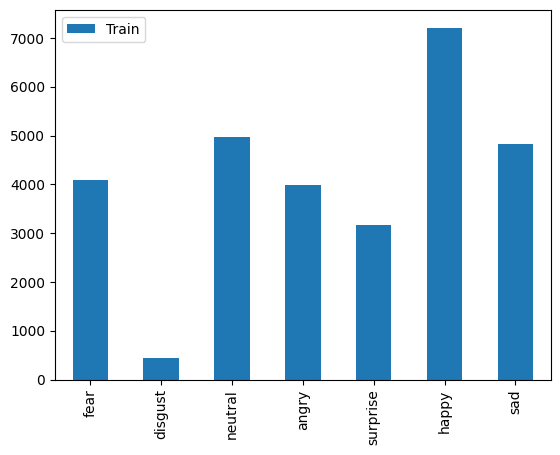

In [7]:
train_counts.T.plot(kind='bar')

## Plotting one image from each Category.

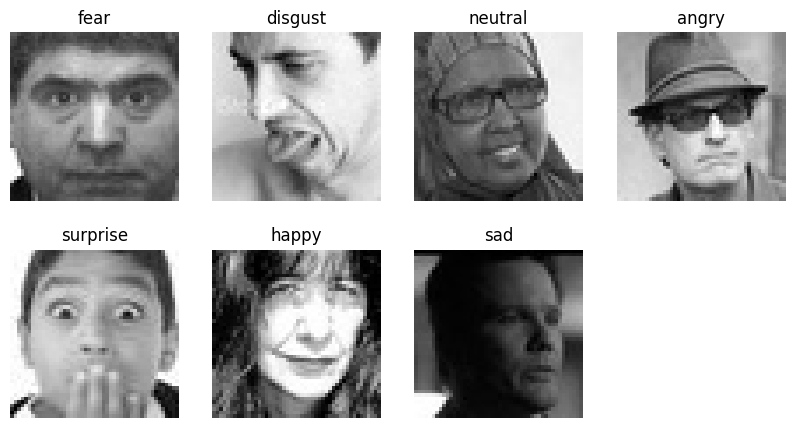

In [9]:
emotions = os.listdir(train_dir)

plt.figure(figsize=(10,8))

for i,emotion in enumerate(emotions,1):
    folder = os.path.join(train_dir,emotion)
    img_path = os.path.join(folder,os.listdir(folder) [43])
    img = plt.imread(img_path)
    plt.subplot(3,4,i)
    plt.imshow(img,cmap='grey')
    plt.title(emotion)
    plt.axis('off')

## Plotting random images from given directory

In [10]:
def plot_image_forms_directory(directory,class_name,num_img):
    image_filesname = os.listdir(directory)

    if len(image_filesname) < num_img:
        print(f'Only found {len(image_filesname)} images in  {directory} diplaying them')
        num_img = len(image_filesname)
        
    selected_img = random.sample(image_filesname,num_img)
    fig,ax = plt.subplots(3,3,figsize=(10,8))
    ax = ax.ravel()

    for i, image_file in enumerate(selected_img):
        image_path = os.path.join(directory, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        ax[i].imshow(image)
        ax[i].set_title(f"Image: {class_name}")
        ax[i].axis('off') 

    plt.tight_layout()
    plt.show()

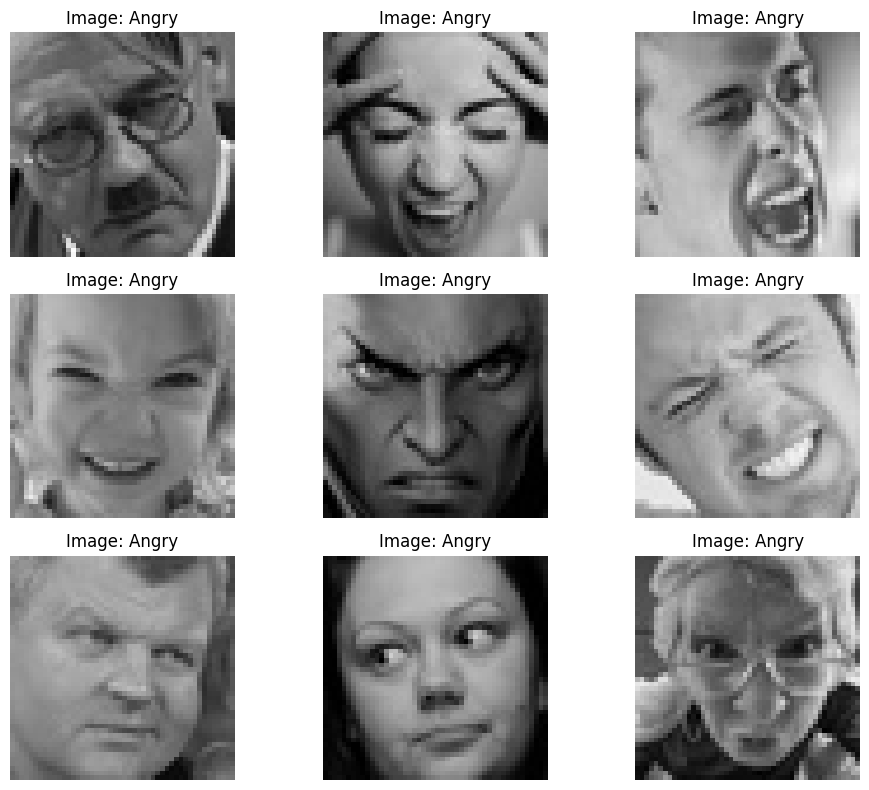

In [11]:
plot_image_forms_directory('emotion_face/train/angry',"Angry",9)

## Checking shapes and channels.

In [12]:
image = 'emotion_face/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) 

if img is not None:
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [13]:
image = 'emotion_face/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image,cv2.IMREAD_GRAYSCALE) 

if img is not None:
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


## Model Building

#### Model 1 : Custom CNN Form Scratch 

In [12]:
train_dir = 'emotion_face/train'
test_dir = 'emotion_face/test'

In [13]:
img_width,img_height = 48,48
batch_size = 64
epochs = 10
num_classes = 7

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generetor = train_datagen.flow_from_directory(
    train_dir,
    target_size= (img_width,img_height),
    batch_size= batch_size,
    class_mode='categorical',
    color_mode = "grayscale",
    subset='training'
)

validation_generetor = train_datagen.flow_from_directory(
    train_dir,
    target_size= (img_width,img_height),
    batch_size= batch_size,
    class_mode='categorical',
    color_mode = "grayscale",
    subset='validation'
)

test_generetor = test_datagen.flow_from_directory(
    test_dir,
    target_size= (img_width,img_height),
    batch_size= batch_size,
    class_mode='categorical',
    color_mode = "grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [15]:
train_class_labels = train_generetor.class_indices

validation_class_labels = validation_generetor.class_indices

test_class_labels = test_generetor.class_indices

In [16]:
print(test_class_labels)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [17]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),kernel_initializer='glorot_uniform',padding='same',input_shape=(img_width,img_height,1)))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(512,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [19]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

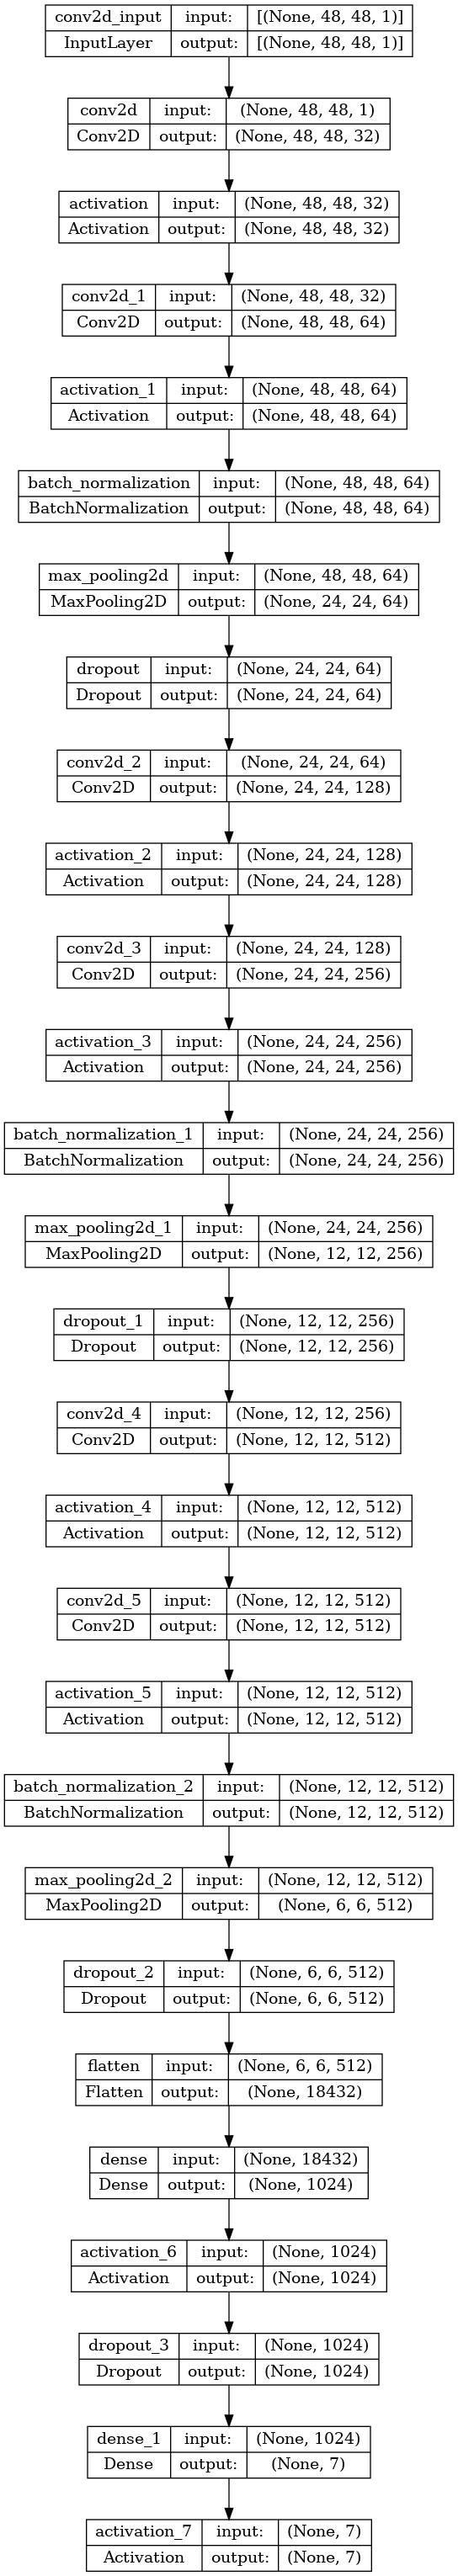

In [21]:
plot_model(model, to_file = 'content/Emotion Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

##### Understanding Callbacks

In [22]:
cnn_path = 'content/Emotion Detection/Custom_CNN_From_Scratch'
model_name = 'model.keras'

model_path = os.path.join(cnn_path,model_name)
model_path

'content/Emotion Detection/Custom_CNN_From_Scratch/model.keras'

In [23]:
checkpoint = ModelCheckpoint(filepath=model_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss'
                            )

In [24]:
earlystopping = EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=3,
                                  verbose=1,
                                  restore_best_weights=True
                                 )

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [26]:
csv_logger = CSVLogger(os.path.join(cnn_path,'trainig.log'))


In [27]:
callbacks = [checkpoint,earlystopping,reduce_lr,csv_logger]

In [28]:
trainig_steps_per_epoch = train_generetor.samples//train_generetor.batch_size+1
validation_steps_per_epoch = validation_generetor.samples//validation_generetor.batch_size+1
test_steps_per_epoch = test_generetor.samples//test_generetor.batch_size+1

In [29]:
history = model.fit(
    train_generetor,
    steps_per_epoch=trainig_steps_per_epoch,
    epochs=5,
    validation_data=validation_generetor,
    validation_steps=validation_steps_per_epoch,
    callbacks=callbacks)

Epoch 1/5
359/359 [==============================] - ETA: 0s - loss: 3.3048 - accuracy: 0.2496
Epoch 1: val_loss improved from inf to 1.79748, saving model to content/Emotion Detection/Custom_CNN_From_Scratch/model.keras
359/359 [==============================] - 1900s 5s/step - loss: 3.3048 - accuracy: 0.2496 - val_loss: 1.7975 - val_accuracy: 0.2522 - lr: 0.0010
Epoch 2/5
359/359 [==============================] - ETA: 0s - loss: 1.7391 - accuracy: 0.2926
Epoch 2: val_loss improved from 1.79748 to 1.74387, saving model to content/Emotion Detection/Custom_CNN_From_Scratch/model.keras
359/359 [==============================] - 1771s 5s/step - loss: 1.7391 - accuracy: 0.2926 - val_loss: 1.7439 - val_accuracy: 0.3045 - lr: 0.0010
Epoch 3/5
359/359 [==============================] - ETA: 0s - loss: 1.6766 - accuracy: 0.3200
Epoch 3: val_loss improved from 1.74387 to 1.68921, saving model to content/Emotion Detection/Custom_CNN_From_Scratch/model.keras
359/359 [============================

##### Plotting Performance Metrics

In [41]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochos_range = range(len(acc))

    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(epochos_range,acc,label="Training Accuracy")
    plt.plot(epochos_range,val_acc,label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title("Training And Validation Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochos_range,loss,label="Training Loss")
    plt.plot(epochos_range,val_loss,label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title("Training And Validation Loss")

    plt.show()
            
    

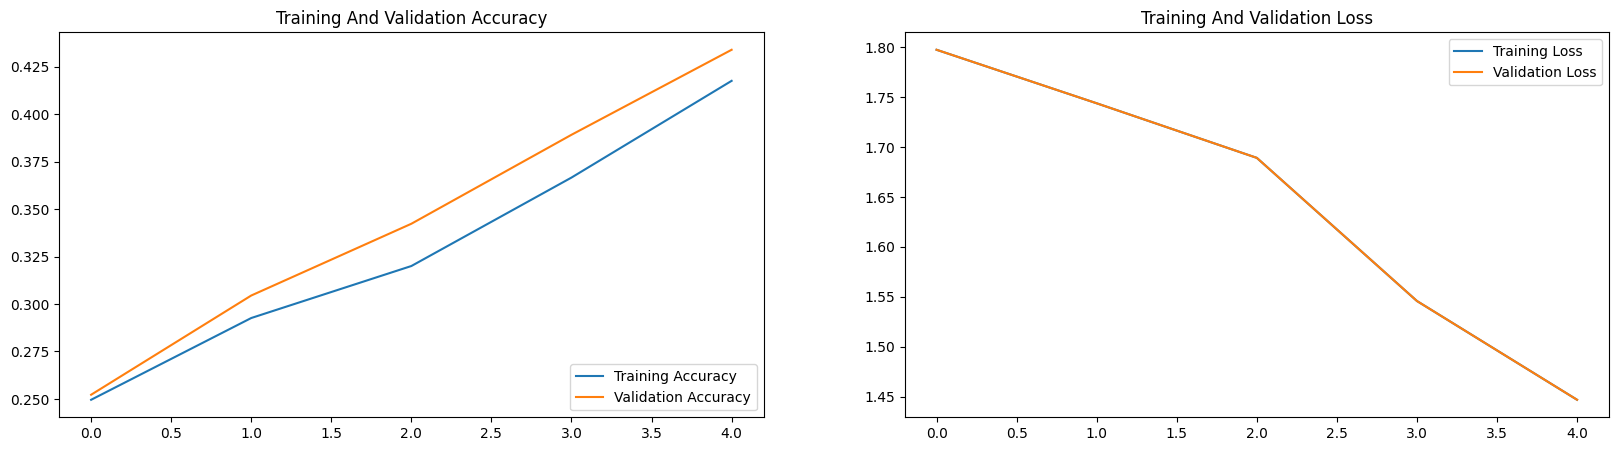

In [42]:
plot_training_history(history)

##### Model Evaluation

In [43]:
train_loss,train_accuracy = model.evaluate(train_generetor)
test_loss,test_accuracy = model.evaluate(test_generetor)

113/113 [==============================] - 100s 886ms/step - loss: 1.4468 - accuracy: 0.4356


##### Plotting Confusion Matrix

113/113 [==============================] - 108s 960ms/step


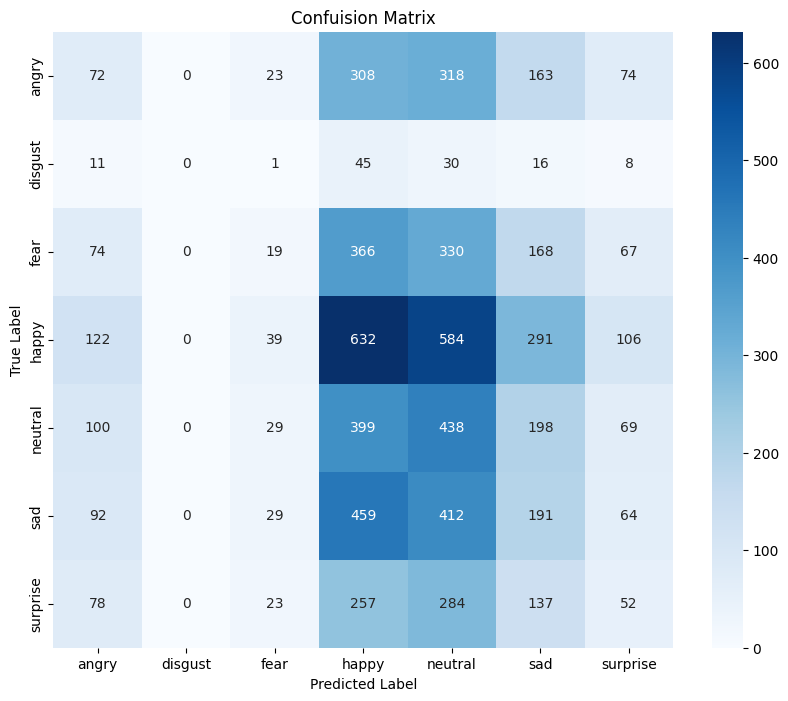

In [49]:
true_classes = test_generetor.classes
predicted_classes = np.argmax(model.predict(test_generetor,test_steps_per_epoch),axis=1)
class_labels = list(test_generetor.class_indices.keys())

cm = confusion_matrix(true_classes,predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confuision Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [51]:
report = classification_report(true_classes,predicted_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       angry       0.13      0.08      0.10       958
     disgust       0.00      0.00      0.00       111
        fear       0.12      0.02      0.03      1024
       happy       0.26      0.36      0.30      1774
     neutral       0.18      0.36      0.24      1233
         sad       0.16      0.15      0.16      1247
    surprise       0.12      0.06      0.08       831

    accuracy                           0.20      7178
   macro avg       0.14      0.15      0.13      7178
weighted avg       0.17      0.20      0.17      7178



/home/shohel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shohel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shohel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Make Prediction

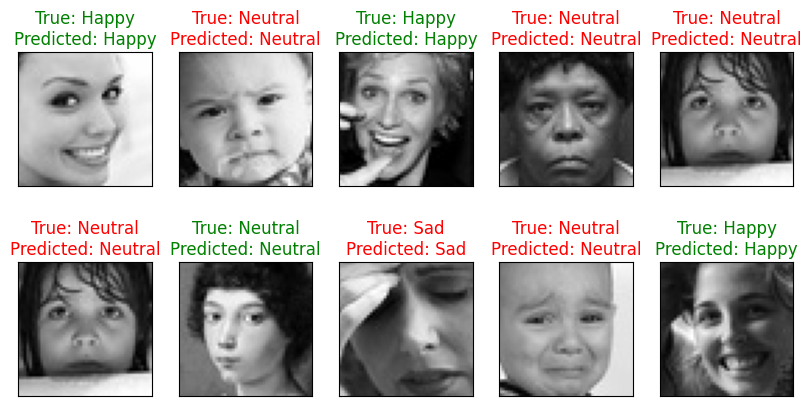

In [76]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
batch_size = test_generetor.batch_size
random_batch = np.random.randint(0,len(test_generetor)-1)
random_img_index = np.random.randint(0,batch_size,10)

fig,axes = plt.subplots(nrows=2,ncols=5,figsize=(10,5),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
    random_img = test_generetor[random_batch][0][random_img_index[i]]
    random_img_labels = np.argmax(test_generetor[random_batch][1][random_img_index[i]], axis=0)
    model_prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]
    ax.imshow(random_img.squeeze(), cmap='gray')
    color = "green" if Emotion_Classes[random_img_labels] == Emotion_Classes[model_prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[model_prediction]}\nPredicted: {Emotion_Classes[model_prediction]}", color=color)

#### Model 2 : Custom CNN Form Scratch With Data Augmentation

In [14]:
train_dir = 'emotion_face/train'
test_dir = 'emotion_face/test'

img_width,img_height = 48,48
batch_size = 64
epochs = 10
num_classes = 7

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generetor = train_datagen.flow_from_directory(
    train_dir,
    target_size= (img_width,img_height),
    batch_size= batch_size,
    class_mode='categorical',
    color_mode = "grayscale",
    subset='training'
)

validation_generetor = train_datagen.flow_from_directory(
    train_dir,
    target_size= (img_width,img_height),
    batch_size= batch_size,
    class_mode='categorical',
    color_mode = "grayscale",
    subset='validation'
)

test_generetor = test_datagen.flow_from_directory(
    test_dir,
    target_size= (img_width,img_height),
    batch_size= batch_size,
    class_mode='categorical',
    color_mode = "grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:

model2 = Sequential()

# First Block
model2.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='glorot_uniform', padding='same', input_shape=(img_width, img_height, 1)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# Second Block
model2.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# Third Block
model2.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# Fully Connected Layers
model2.add(Flatten())
model2.add(Dense(1024))
model2.add(Activation('relu'))
model2.add(Dropout(0.4))

model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


2024-07-09 10:25:49.255425: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 75497472 exceeds 10% of free system memory.
2024-07-09 10:25:49.335763: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 75497472 exceeds 10% of free system memory.
2024-07-09 10:25:49.362921: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 75497472 exceeds 10% of free system memory.


In [17]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

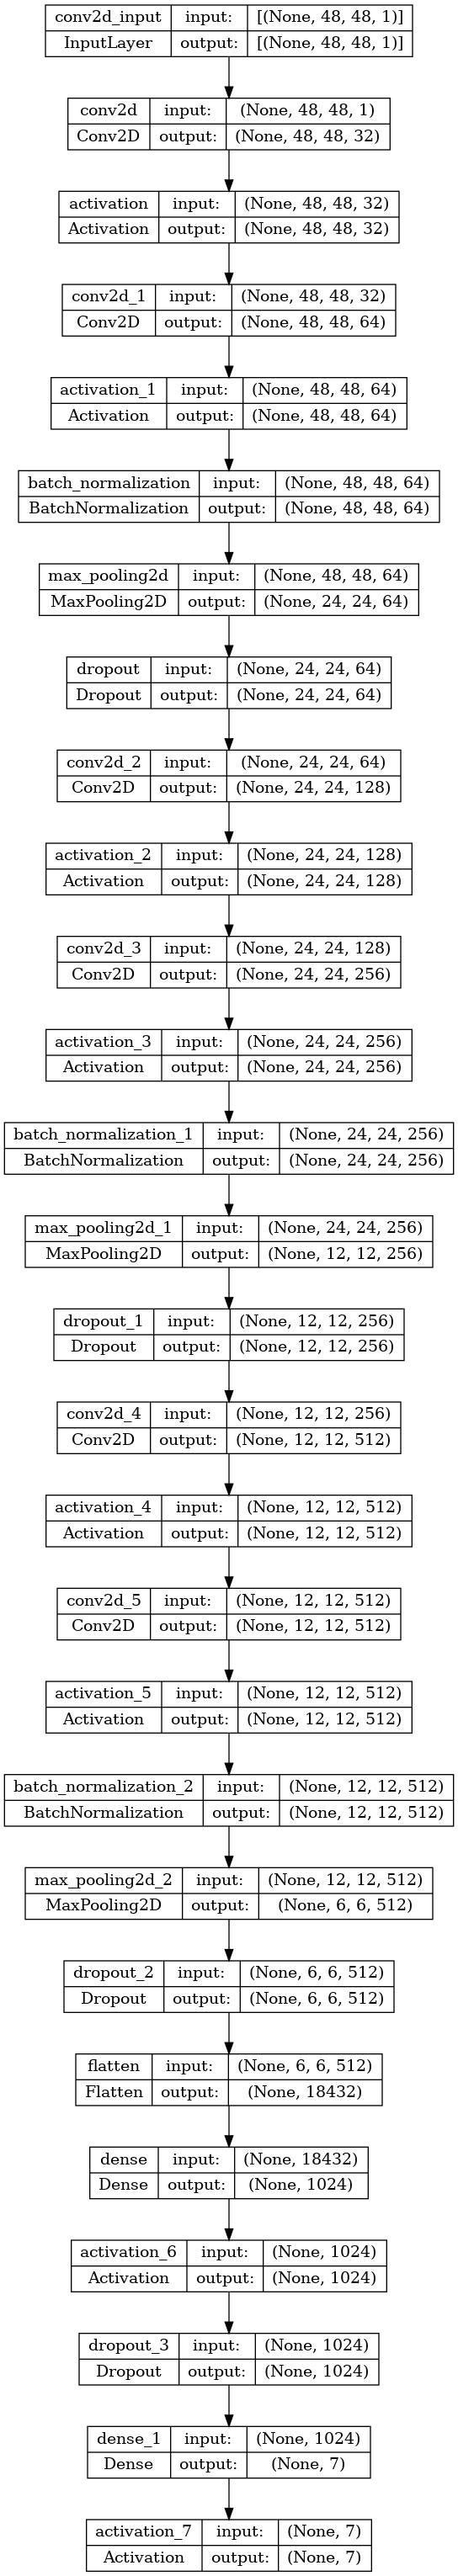

In [18]:
plot_model(model2, to_file = 'content/Emotion Detection/Custom_CNN_With_Augmentation/Architecture.png',
           show_shapes=True, show_layer_names=True)

In [19]:
cnn_path = 'content/Emotion Detection/Custom_CNN_With_Augmentation'
model_name = 'model.keras'

model_path = os.path.join(cnn_path,model_name)
model_path

checkpoint = ModelCheckpoint(filepath=model_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss'
                            )

earlystopping = EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=3,
                                  verbose=1,
                                  restore_best_weights=True
                                 )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'trainig.log'))

callbacks = [checkpoint,earlystopping,reduce_lr,csv_logger]



In [21]:
trainig_steps_per_epoch = train_generetor.samples//train_generetor.batch_size+1
validation_steps_per_epoch = validation_generetor.samples//validation_generetor.batch_size+1
test_steps_per_epoch = test_generetor.samples//test_generetor.batch_size+1

history = model2.fit(
    train_generetor,
    steps_per_epoch=trainig_steps_per_epoch,
    epochs=12,
    validation_data=validation_generetor,
    validation_steps=validation_steps_per_epoch,
    callbacks=callbacks)

Epoch 1/12
359/359 [==============================] - ETA: 0s - loss: 2.9496 - accuracy: 0.2268
Epoch 1: val_loss improved from inf to 1.84746, saving model to content/Emotion Detection/Custom_CNN_With_Augmentation/model.keras
359/359 [==============================] - 1985s 6s/step - loss: 2.9496 - accuracy: 0.2268 - val_loss: 1.8475 - val_accuracy: 0.2315 - lr: 0.0010
Epoch 2/12
359/359 [==============================] - ETA: 0s - loss: 1.8190 - accuracy: 0.2470
Epoch 2: val_loss improved from 1.84746 to 1.79938, saving model to content/Emotion Detection/Custom_CNN_With_Augmentation/model.keras
359/359 [==============================] - 2267s 6s/step - loss: 1.8190 - accuracy: 0.2470 - val_loss: 1.7994 - val_accuracy: 0.2510 - lr: 0.0010
Epoch 3/12
359/359 [==============================] - ETA: 0s - loss: 1.8132 - accuracy: 0.2471
Epoch 3: val_loss did not improve from 1.79938
359/359 [==============================] - 2194s 6s/step - loss: 1.8132 - accuracy: 0.2471 - val_loss: 1.80

In [22]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochos_range = range(len(acc))

    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(epochos_range,acc,label="Training Accuracy")
    plt.plot(epochos_range,val_acc,label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title("Training And Validation Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochos_range,loss,label="Training Loss")
    plt.plot(epochos_range,val_loss,label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title("Training And Validation Loss")

    plt.show()
            

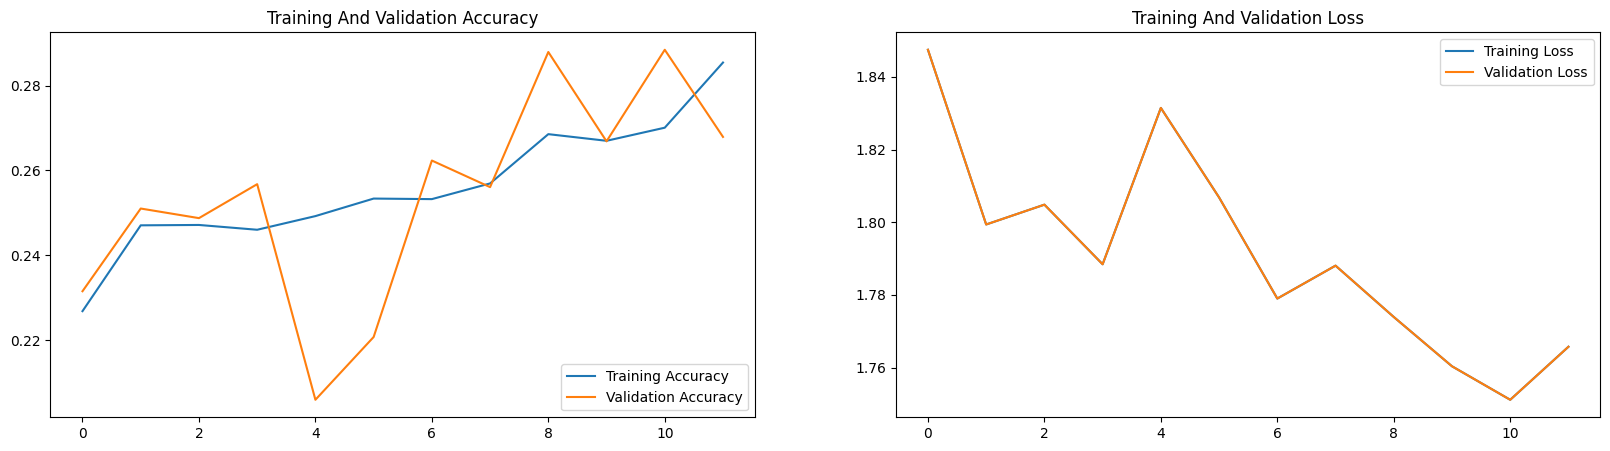

In [23]:
plot_training_history(history)

113/113 [==============================] - 133s 1s/step


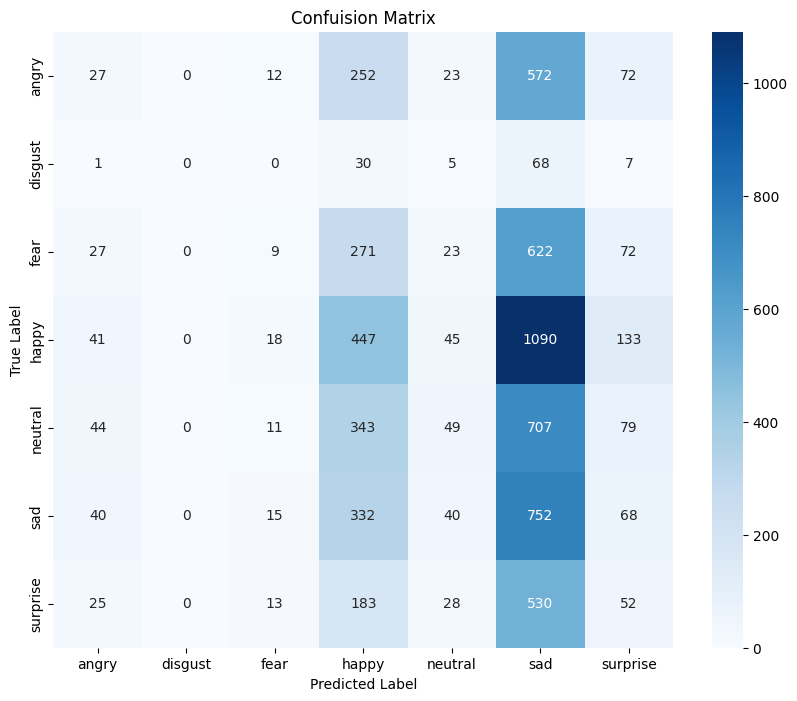

In [24]:
true_classes = test_generetor.classes
predicted_classes = np.argmax(model2.predict(test_generetor,test_steps_per_epoch),axis=1)
class_labels = list(test_generetor.class_indices.keys())

cm = confusion_matrix(true_classes,predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confuision Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [27]:
report = classification_report(true_classes,predicted_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       angry       0.13      0.03      0.05       958
     disgust       0.00      0.00      0.00       111
        fear       0.12      0.01      0.02      1024
       happy       0.24      0.25      0.25      1774
     neutral       0.23      0.04      0.07      1233
         sad       0.17      0.60      0.27      1247
    surprise       0.11      0.06      0.08       831

    accuracy                           0.19      7178
   macro avg       0.14      0.14      0.10      7178
weighted avg       0.18      0.19      0.14      7178



/home/shohel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shohel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shohel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


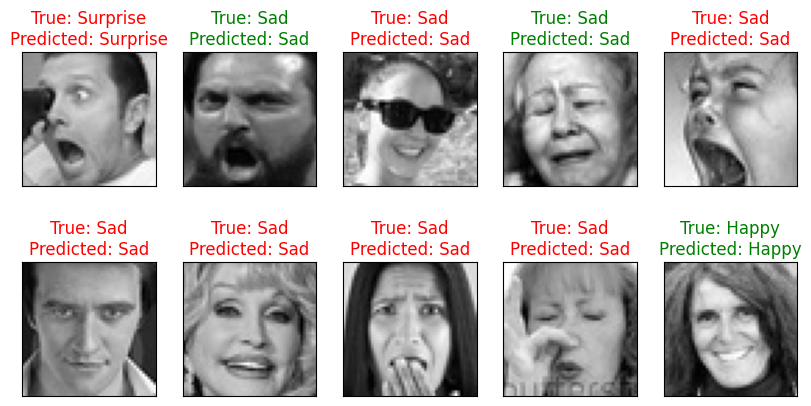

In [26]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
batch_size = test_generetor.batch_size
random_batch = np.random.randint(0,len(test_generetor)-1)
random_img_index = np.random.randint(0,batch_size,10)

fig,axes = plt.subplots(nrows=2,ncols=5,figsize=(10,5),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
    random_img = test_generetor[random_batch][0][random_img_index[i]]
    random_img_labels = np.argmax(test_generetor[random_batch][1][random_img_index[i]], axis=0)
    model_prediction = np.argmax(model2.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]
    ax.imshow(random_img.squeeze(), cmap='gray')
    color = "green" if Emotion_Classes[ran_img_labels] == Emotion_Classes[model_pdomrediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[model_prediction]}\nPredicted: {Emotion_Classes[model_prediction]}", color=color)

#### Model 4 : Alexnet Architecture

#### Model 3 : VGG Architecture

In [14]:
train_dir = 'emotion_face/train'
test_dir = 'emotion_face/test'
 
img_width,img_height = 244,244
batch_size = 64
epochos = 10
num_classes = 7

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'rgb',
    subset='training',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'rgb'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


##### Introducing Class wieghts for imbalanced data

In [16]:
classes = np.array(train_generator.classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes = np.unique(classes),
    y= classes
)

class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [17]:
vgg = VGG16(input_shape=(224,224,3),include_top=False,weights = 'imagenet')
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
for layer in vgg.layers[:-3]:
    layer.trainable = False    

In [19]:
x = Flatten()(vgg.output)
x = Dense(1024,activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

x = Dense(512,activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

output =  Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)
model = Model(inputs = vgg.input,outputs = output)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

##### Applying callbacks

In [21]:
cnn_path = 'content/Emotion Detection/VGG16_Transfer_Learning'
model_name = 'model.keras'

model_path = os.path.join(cnn_path,model_name)
model_path

checkpoint = ModelCheckpoint(filepath=model_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss'
                            )

earlystopping = EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=3,
                                  verbose=1,
                                  restore_best_weights=True
                                 )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'trainig.log'))

callbacks = [checkpoint,earlystopping,reduce_lr,csv_logger]

trainig_steps_per_epoch = train_generator.samples//train_generator.batch_size+1
test_steps_per_epoch = test_generator.samples//test_generator.batch_size+1

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=trainig_steps_per_epoch,
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch,
    epochs = 3,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/3
 12/449 [..............................] - ETA: 2:55:02 - loss: 2.4614 - accuracy: 0.1354

KeyboardInterrupt: 

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochos_range = range(len(acc))

    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(epochos_range,acc,label="Training Accuracy")
    plt.plot(epochos_range,val_acc,label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title("Training And Validation Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochos_range,loss,label="Training Loss")
    plt.plot(epochos_range,val_loss,label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title("Training And Validation Loss")

    plt.show()
            

In [ ]:
plot_training_history(history)

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model2.predict(test_generator,test_steps_per_epoch),axis=1)
class_labels = list(test_generetor.class_indices.keys())

cm = confusion_matrix(true_classes,predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confuision Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
report = classification_report(true_classes,predicted_classes,target_names=class_labels)
print(report)

In [ ]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
batch_size = test_generator.batch_size
random_batch = np.random.randint(0,len(test_generetor)-1)
random_img_index = np.random.randint(0,batch_size,10)

fig,axes = plt.subplots(nrows=2,ncols=5,figsize=(10,5),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_labels = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)
    model_prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]
    ax.imshow(random_img.squeeze(), cmap='gray')
    color = "green" if Emotion_Classes[random_img_labels] == Emotion_Classes[model_prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[model_prediction]}\nPredicted: {Emotion_Classes[model_prediction]}", color=color)

In [ ]:
model.save('vgg.model')

#### Model 5 : Resnet Architecture

In [23]:
train_dir = 'emotion_face/train'
test_dir = 'emotion_face/test'
 
img_width,img_height = 244,244
batch_size = 64
epochos = 10
num_classes = 7

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'rgb',
    subset='training',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'rgb'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


##### Introducing Class wieghts for imbalanced data

In [25]:
classes = np.array(train_generator.classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes = np.unique(classes),
    y= classes
)

class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [26]:
base_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))
model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D()
    Dense(512,activation='relu'),
    Dropout(0.1),
    Dense(256,activation='relu'),
    Dropout(0.1),
    Dense(128,activation='relu'),
    Dropout(0.1),
    Dense(7,activation='softmac')
    
])


KeyboardInterrupt



In [ ]:
model.compile(optimizer=Adamax(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


##### Applying CallBacks

In [ ]:
cnn_path = 'content/Emotion Detection/ResNet50_Transfer_Learning'
model_name = 'model.keras'

model_path = os.path.join(cnn_path,model_name)
model_path

checkpoint = ModelCheckpoint(filepath=model_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss'
                            )

earlystopping = EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=3,
                                  verbose=1,
                                  restore_best_weights=True
                                 )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'trainig.log'))

callbacks = [checkpoint,earlystopping,reduce_lr,csv_logger]

trainig_steps_per_epoch = train_generator.samples//train_generator.batch_size+1
test_steps_per_epoch = test_generator.samples//test_generator.batch_size+1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=trainig_steps_per_epoch,
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch,
    epochs = 3,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochos_range = range(len(acc))

    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(epochos_range,acc,label="Training Accuracy")
    plt.plot(epochos_range,val_acc,label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title("Training And Validation Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochos_range,loss,label="Training Loss")
    plt.plot(epochos_range,val_loss,label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title("Training And Validation Loss")

    plt.show()

In [ ]:
plot_training_history(history)

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model2.predict(test_generator,test_steps_per_epoch),axis=1)
class_labels = list(test_generetor.class_indices.keys())

cm = confusion_matrix(true_classes,predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confuision Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
report = classification_report(true_classes,predicted_classes,target_names=class_labels)
print(report)

In [ ]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
batch_size = test_generator.batch_size
random_batch = np.random.randint(0,len(test_generetor)-1)
random_img_index = np.random.randint(0,batch_size,10)

fig,axes = plt.subplots(nrows=2,ncols=5,figsize=(10,5),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_labels = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)
    model_prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]
    ax.imshow(random_img.squeeze(), cmap='gray')
    color = "green" if Emotion_Classes[random_img_labels] == Emotion_Classes[model_prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[model_prediction]}\nPredicted: {Emotion_Classes[model_prediction]}", color=color)